In [1]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d shaunthesheep/microsoft-catsvsdogs-dataset

microsoft-catsvsdogs-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
from zipfile import ZipFile
dataset='/content/microsoft-catsvsdogs-dataset.zip'
with ZipFile(dataset,'r') as zip:
  zip.extractall()
  print("Extracted dataset")

Extracted dataset


In [5]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import splitfolders

In [7]:
input_folder = '/content/PetImages'


# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, (.8, .2).
# Train, val, test
splitfolders.ratio(input_folder,
                   output="output",
                   seed=42,
                   ratio=(.8,.2),
                   group_prefix=None)

Copying files: 25002 files [00:20, 1218.72 files/s]


In [8]:
import os
os.remove("/content/output/train/Cat/666.jpg")
os.remove("/content/output/train/Dog/11702.jpg")

In [9]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator


In [10]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
training_set = train_datagen.flow_from_directory('/content/output/train',
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'binary')


Found 19996 images belonging to 2 classes.


In [11]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory('/content/output/val',
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'binary')

Found 5002 images belonging to 2 classes.


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Reshape

In [13]:
classifier=Sequential()


In [14]:
train_images, train_labels = next(training_set)
test_images, test_labels = next(test_set)

print("Train images shape:", train_images.shape)
print("Test images shape:", test_images.shape)


Train images shape: (32, 64, 64, 3)
Test images shape: (32, 64, 64, 3)


In [15]:
classifier.add(Convolution2D(filters=32,kernel_size=(3,3),activation='relu',input_shape=[64,64,3]))
classifier.add(MaxPooling2D())
classifier.add(Flatten())
classifier.add(Dense(activation='relu',units=128))
classifier.add(Dense(activation='sigmoid',units=1))


In [16]:
classifier.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [17]:
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

path = Path("/content/output/train/Dog").rglob("*.jpg")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:819: UserWarning: Truncated File Read
  warnings.warn(str(msg))


In [18]:
classifier.fit(x=training_set,validation_data=test_set,epochs=5)

Epoch 1/5
625/625 [==============================] - 185s 294ms/step - loss: 0.6191 - accuracy: 0.6620 - val_loss: 0.5484 - val_accuracy: 0.7239
Epoch 2/5
625/625 [==============================] - 181s 290ms/step - loss: 0.5538 - accuracy: 0.7159 - val_loss: 0.5227 - val_accuracy: 0.7375
Epoch 3/5
625/625 [==============================] - 202s 323ms/step - loss: 0.5225 - accuracy: 0.7399 - val_loss: 0.5043 - val_accuracy: 0.7503
Epoch 4/5
625/625 [==============================] - 184s 294ms/step - loss: 0.5017 - accuracy: 0.7560 - val_loss: 0.5004 - val_accuracy: 0.7571
Epoch 5/5
625/625 [==============================] - 205s 327ms/step - loss: 0.4866 - accuracy: 0.7658 - val_loss: 0.4986 - val_accuracy: 0.7625


In [19]:
import numpy as np
from keras.preprocessing import image

In [41]:
from keras.utils import load_img, img_to_array
test_image = load_img('/content/predict.jpg', target_size = (64, 64))
test_image = img_to_array(test_image)
print("shape of test image:",test_image.shape)

shape of test image: (64, 64, 3)


In [34]:
from warnings import filterwarnings
import tensorflow as tf
from tensorflow import io
from tensorflow import image
from matplotlib import pyplot as plt

shape of test image: (1, 64, 64, 3)
1/1 [==============================] - 0s 29ms/step
<dtype: 'uint8'>


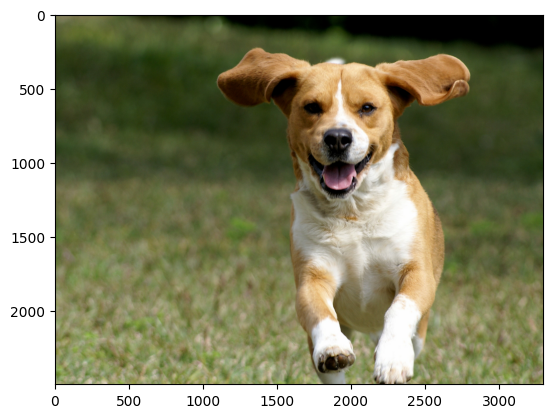

Dog


In [42]:
test_image = test_image.reshape((1,) + test_image.shape)
print("shape of test image:",test_image.shape)
result=classifier.predict(test_image)

tf_img = io.read_file("/content/predict.jpg")
tf_img = image.decode_png(tf_img, channels=3)
print(tf_img.dtype)
plt.imshow(tf_img)
plt.show()
if result[0][0]==1:
  print("Dog")
else:
  print("Cat")